In [36]:
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import re
from sklearn import preprocessing as pre
from sklearn.metrics.pairwise import cosine_similarity
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import precision_recall_curve, f1_score
from collections import OrderedDict
from operator import itemgetter
import itertools
from collections import Counter
import json
import os

# load the dataset
#nsf_dataset = pandas.read_csv('nsf-search-AR.csv')
#dataset = pandas.read_csv('newDATA-16Oct2020.csv')
dataset = pandas.read_csv('full-analysis-Jan24.csv')
alias = pandas.read_csv('term-bucketing.csv')
replace = pandas.read_csv('replacements-new.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wzb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wzb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [37]:
def cosine_model(m, classes=None, **cos_kws):

    encode = pre.MultiLabelBinarizer(classes=classes)
    tags = encode.fit_transform(m)

    cos = cosine_similarity(tags.T.dot(tags))
    cos -= np.diag(cos.diagonal())
    return cos

In [39]:
control_keywords = []
uncontrol_keywords =[]
classification_code = []

for i in range(0,len(dataset)):
 
    
    class_code = dataset['Classification code'][i]
    res = isinstance(class_code, str)
    if res == False:
        dataset['Classification code'][i] = "not labeled"
        class_code = dataset['Classification code'][i]
    class_code = re.split(';',class_code)
    
       
    control_keys = dataset['Controlled/Subject terms'][i]
    res = isinstance(control_keys, str)
    if res == False:
        dataset['Controlled/Subject terms'][i] = "not labeled"
        control_keys = dataset['Controlled/Subject terms'][i]
    #dataset['LowLevel'] = control_keys.lower()
    control_keys = re.split(';',control_keys)

    
    uncontrol_keys = dataset['Uncontrolled terms'][i]
    res = isinstance(uncontrol_keys, str)
    if res == False:
        dataset['Uncontrolled terms'][i] = "not labeled"
        uncontrol_keys = dataset['Uncontrolled terms'][i]
    uncontrol_keys = re.split(';',uncontrol_keys)
  
    for j in range(0,len(control_keys)):
        control_keys[j] = control_keys[j].lower()

    for k in range(0,len(uncontrol_keys)):
        uncontrol_keys[k] = uncontrol_keys[k].lower()
        
    #for l in range(0,len(class_code)):
        #class_code[l] = class_code[l].lower()
        
    control_keywords.append(control_keys)
    uncontrol_keywords.append(uncontrol_keys)
    classification_code.append(class_code)


In [40]:
for i in range(0,len(dataset)):
    dataset['LowLevel'][i]=dataset['Controlled/Subject terms'][i].lower()

C:\Users\wzb\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [41]:
for i in range(0, len(dataset)):
    low=dataset['LowLevel'][i]
    terms=low.split(';')
    terms_to_delete =[]
    for l in range(0,len(terms)):
        term=terms[l]
        for k in range(0,len(replace)):
            check_term = replace['FIND'][k]
            replace_term = replace['REPLACE'][k]
            if check_term == term:
                if replace['REPLACE'][k]=="DELETE":
                    terms_to_delete.append(term)
                if replace['REPLACE'][k]!="DELETE":
                    terms[l]=replace_term

    for m in range(0, len(terms_to_delete)):
        terms.remove(terms_to_delete[m])
    
    dataset['LowLevel'][i]=terms



C:\Users\wzb\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [42]:
all_mids = []
for i in range(0,len(dataset)):
    mid=[]
    terms=dataset['LowLevel'][i]
    for k in range(0,len(terms)):
        for j in range(0,len(alias)):
            low = terms[k]
            if low == alias['LowLevel'][j]:
                mid.append(alias['MidLevel'][j])    
    dataset['MidLevel'][i]=list(set(mid))
    all_mids.append(list(set(mid)))


C:\Users\wzb\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [45]:
concat = []
for i in range(0,len(all_mids)):
    mid_list = all_mids[i]
    for j in range(0,len(mid_list)):
        if j==0:
            string_new = mid_list[j]
        else:
            string_new = string_new + ';' + mid_list[j]
    concat.append(string_new)
    

In [46]:
dataset['concat_test']=concat
dataset['midlvl']=concat
dataset.to_csv('test-new.csv')

In [47]:
#create new columns in database that are semicolon separated
llvl = []
for i in range(0,len(dataset)):
    low_list = str(dataset['LowLevel'][i])
#    mid_list = str(dataset['MidLevel'][i])
    low_list=re.sub("'","",low_list)
    low_list=re.sub(", ",";",low_list)
    low_list=re.sub('\[','',low_list)
    low_list=re.sub('\]','',low_list)
#    mid_list=re.sub("'","",mid_list)
#    mid_list=re.sub(", ",";",mid_list)
#    mid_list=re.sub('\[','',mid_list)
#    mid_list=re.sub('\]','',mid_list)
#    dataset['midlvl'][i]=mid_list
    llvl.append(low_list)
dataset['lowlvl']=llvl

In [48]:
llvl = []
counter=0
for i in range(0,len(dataset)):
    low = str(dataset['lowlvl'][i])
    if low.lower()=='':
        counter=counter+1
        dataset['lowlvl'][i]='not labeled'
        
#print(counter)

C:\Users\wzb\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [12]:
combined_tags = []
skip_index=[]
#df.drop(columns=['combinedTags'])
for i in range (0, len(dataset)):
    
    if pandas.isna(dataset.loc[i, 'lowlvl']) == True:
        lowlevel_terms = ''
        skip_index.append(i)
    if pandas.isna(dataset.loc[i, 'lowlvl']) == False: 
        lowlevel_terms = dataset['lowlvl'][i]
        
    if pandas.isna(dataset.loc[i, 'Uncontrolled terms']) == True:
        uncontrol_terms = ''
        skip_index.append(i)
    if pandas.isna(dataset.loc[i, 'Uncontrolled terms']) == False:
        uncontrol_terms = dataset['Uncontrolled terms'][i]
    
    if pandas.isna(dataset.loc[i, 'Classification code']) == True:
        class_terms = ''
        skip_index.append(i)
    if pandas.isna(dataset.loc[i, 'Classification code']) == False: 
        class_terms = dataset['Classification code'][i]
        
    if pandas.isna(dataset.loc[i, 'midlvl']) == True:
        midlevel_terms = ''
        skip_index.append(i)
    if pandas.isna(dataset.loc[i, 'midlvl']) == False: 
        midlevel_terms = dataset['midlvl'][i]        
    
    
    lowlevel_terms = re.sub(' ', '_',lowlevel_terms)
    uncontrol_terms = re.sub(' ', '_',uncontrol_terms)
    class_terms = re.sub(' ', '_',class_terms)
    midlevel_terms = re.sub(' ', '_',midlevel_terms)
    
    #replace spaces with 
    lowlevel_terms = re.split(';', lowlevel_terms)
    uncontrol_terms = re.split(';', uncontrol_terms)
    class_terms = re.split(';', class_terms)
    midlevel_terms = re.split(';', midlevel_terms)
    
    text = str(lowlevel_terms) + str(uncontrol_terms) + str(class_terms) + str(midlevel_terms)
    #text = re.sub('.','_',text)
    text = re.sub('[^_a-zA-Z0-9]', ' ', text)
    text = text.lower()
    #text=re.sub("(\\d|\\W)+"," ",text)
    text = text.lstrip()
    text = text.rstrip()
    text = re.sub(' +', ' ',text)
    combined_tags.append(text)
    
dataset['combinedTagsNew'] = combined_tags
skip_index = list(set(skip_index))

In [13]:
##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords
#new_words = ["br", "use", "award","project","research","using","new","based","nsf","develop","application"] 
#stop_words = stop_words.union(new_words)

corpus = []
#df.drop(columns=['cleanAbstract'])

for i in range(0, len(dataset)):
    #Remove punctuations
    text = re.sub('[^a-zA-Z0-9]', ' ', dataset['Abstract'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    #text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)
    
dataset['cleanAbstract'] = corpus
#https://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits_active_learning.html

In [14]:
dataset['TagsPlusAbstract'] = dataset['combinedTagsNew'] + dataset['cleanAbstract'] 

In [221]:
df = dataset.copy()
df['LowLevel'] = df['lowlvl']
df['MidLevel'] = df['midlvl']
new_df = df.drop(columns=['lowlvl', 'midlvl','combinedTagsNew','combinedTags','cleanAbstract','TagsPlusAbstract','Unnamed: 0','Unnamed: 0.1'])
dataset.to_csv('full-analysis-Jan24.csv')
new_df.to_csv('FindAR-Jan2021.csv')

In [304]:
df = dataset.copy()
df['LowLevel']=df['lowlvl']
df['MidLevel']=df['midlvl']
new_df = df.drop(columns=['lowlvl', 'concat_test','midlvl','combinedTagsNew','Unnamed: 0.1','combinedTags','cleanAbstract','TagsPlusAbstract','Unnamed: 0'])
new_df.to_csv('FindAR-Jan2021.csv')

In [305]:
dataset.to_csv('full-analysis-Jan24.csv')

In [15]:
midlvl=[]

for i in range(0,len(dataset)):
    set_string = []
    terms = dataset["midlvl"][i].split(";")
    for j in range(0, len(terms)):
        set_string.append(terms[j])
    midlvl.append(set_string)


In [16]:
lowlvl=[]
for i in range(0,len(dataset)):
    set_string = []
    terms = str(dataset["lowlvl"][i]).split(";")
    for j in range(0, len(terms)):
        set_string.append(terms[j])
    lowlvl.append(set_string)

In [17]:
document = lowlvl

# Get all of the unique entries you have
varnames_low = tuple(sorted(set(itertools.chain(*document))))

# Get a list of all of the combinations you have
expanded = [tuple(itertools.combinations(d, 2)) for d in document]
expanded = itertools.chain(*expanded)

# Sort the combinations so that A,B and B,A are treated the same
expanded = [tuple(sorted(d)) for d in expanded]

# count the combinations
c = Counter(expanded)


# Create the table
table_low = np.zeros((len(varnames_low),len(varnames_low)), dtype=int)

for i, v1 in enumerate(varnames_low):
    for j, v2 in enumerate(varnames_low[i:]):        
        j = j + i 
        table_low[i, j] = c[v1, v2]
        table_low[j, i] = c[v1, v2]

# Display the output
#for row in table:
#    print(row)

In [18]:
document = midlvl

# Get all of the unique entries you have
varnames_mid = tuple(sorted(set(itertools.chain(*document))))

# Get a list of all of the combinations you have
expanded = [tuple(itertools.combinations(d, 2)) for d in document]
expanded = itertools.chain(*expanded)

# Sort the combinations so that A,B and B,A are treated the same
expanded = [tuple(sorted(d)) for d in expanded]

# count the combinations
c = Counter(expanded)


# Create the table
table_mid = np.zeros((len(varnames_mid),len(varnames_mid)), dtype=int)

for i, v1 in enumerate(varnames_mid):
    for j, v2 in enumerate(varnames_mid[i:]):        
        j = j + i 
        table_mid[i, j] = c[v1, v2]
        table_mid[j, i] = c[v1, v2]

In [24]:
mids = pandas.DataFrame()
counter=0
freq_count = []
for i in range(0,len(varnames_mid)):
    counter = counter-1
    freq = 0;
    mid_test = varnames_mid[i]
    for j in range(0,len(dataset)):
        #res = isinstance(test_string, str) 
        test = dataset["midlvl"][j].split(";")
        for k in range(0,len(test)):
            if mid_test == test[k]:
                freq = freq+1
    freq_count.append(freq)
    #print(counter)


mids['names']=varnames_mid
mids['freq']=freq_count

mids.to_csv('AllMidLvlTerms.csv')

In [35]:
AllLowLvlTerms = []
for i in range(0,len(dataset)):
    terms=dataset['lowlvl'][i].split(';')
    for j in range(0, len(terms)):
        AllLowLvlTerms.append(terms[j])
b= list(set(AllLowLvlTerms))

df = pandas.DataFrame()
df['LowLevel']=b
counter = len(df)
freq_count = []
mid_levels = []

for i in range(0, len(df['LowLevel'])):
    string1 = df['LowLevel'][i]
    for j in range(0, len(alias['LowLevel'])):
        string2 = alias['LowLevel'][j]
        if string1==string2:
            mid_levels.append(alias['MidLevel'][j])

#df['MidLevel']=mid_levels
df.to_csv('AllLowLvlTerms.csv') 

In [34]:
len(b)

2542

In [26]:
alias

,LowLevel,MidLevel
0,kalman filters,artificial intelligence
1,agents,artificial intelligence
2,frequency response,artificial intelligence
3,gradient methods,artificial intelligence
4,set theory,artificial intelligence
...,...,...
2655,smart city,smart cities
2656,web sites,web services
2657,content based retrieval,data
2658,computer generated holography,graphics


C:\Users\wzb\Anaconda3\lib\site-packages\seaborn\matrix.py:595: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


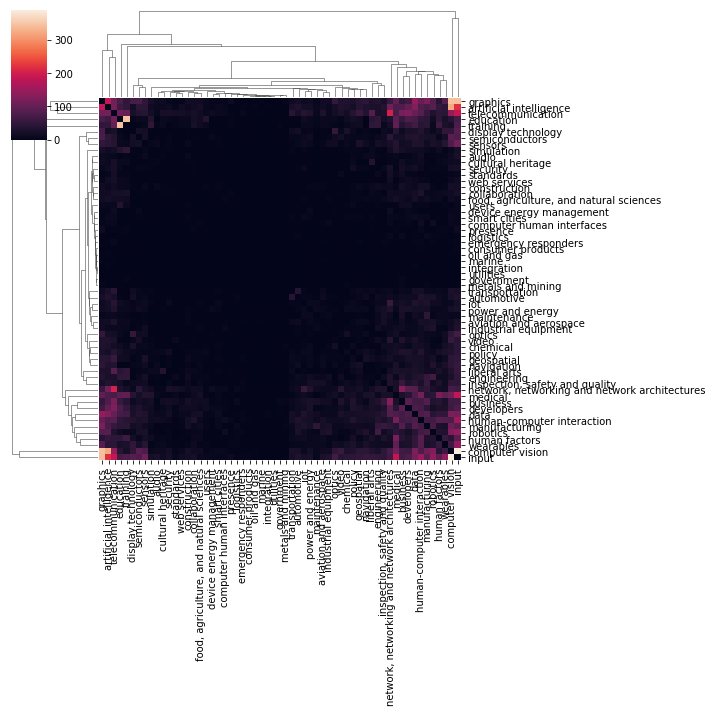

In [20]:
df_table_mid = pandas.DataFrame(table_mid)
sns.clustermap(df_table_mid,xticklabels=varnames_mid, yticklabels=varnames_mid)
#sns.heatmap(table, xlabel=midlvl_names)

C:\Users\wzb\Anaconda3\lib\site-packages\seaborn\matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


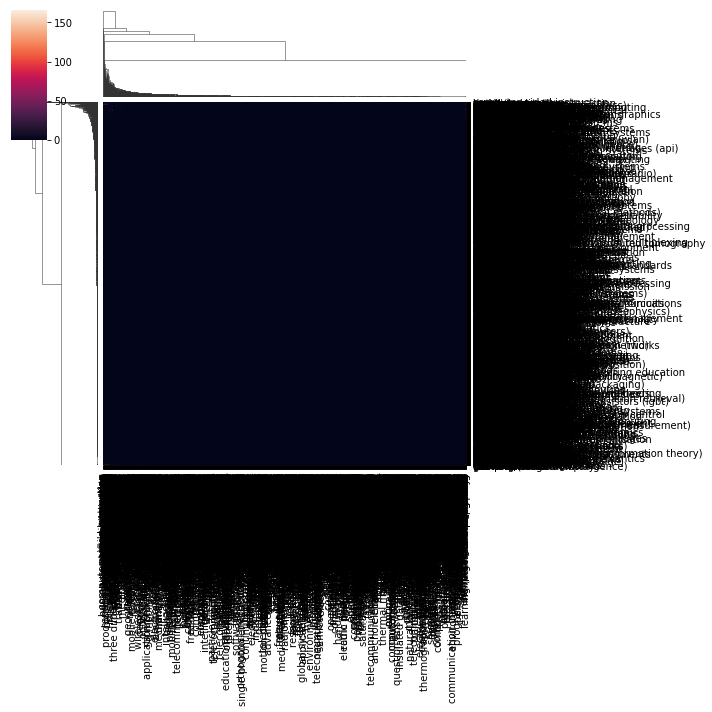

In [21]:
df_table_low = pandas.DataFrame(table_low)
sns.clustermap(df_table_low,xticklabels=varnames_low, yticklabels=varnames_low)

In [ ]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

    
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
plt.rcdefaults()
fig, ax = plt.subplots()

#ax.plot([1,3,2])

set_size(5,10)
plt.gcf().subplots_adjust(left=0.50)

# Example data
low_terms = low["LowLevel"]
mid_terms = mid["names"]
low_freq = low["freq"]
mid_freq = mid["freq"]

y_pos = np.arange(len(mid_terms))



rects = ax.barh(y_pos, mid_freq)
ax.set_yticks(y_pos)
ax.set_yticklabels(mid_terms)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Count')
ax.set_title('Frequency of Mid-Level Terms')


#for index, value in enumerate(mid_freq):
    #plt.text(value, index, str(value))

#plt.figure(figsize=(1,100))
fig.savefig("Page1.pdf")
plt.show()

In [57]:
numpy.savetxt("lowlevel-cooccurrence-Jan27.csv", table, delimiter=",")

In [204]:
vectorizer = TfidfVectorizer()
def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]
TFidf_scores = []
#int(TFidf_scores)
for i in range(0,len(dataset)):
    row_scores =[]
    for j in range(0,len(dataset)):
        score = cosine_sim(dataset['cleanAbstract'][i], dataset['cleanAbstract'][j])
        row_scores.append(score)
        #rint(score)
        #TFidf_scores[i,j].astype(float)
        #Tfidf_scores[i,j] = score
    TFidf_scores.append(row_scores)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


In [205]:
top_20 = []
for i in range(len(TFidf_scores)):
    a = TFidf_scores[i]
    l = OrderedDict(sorted(enumerate(a), key=itemgetter(1),reverse=True))
    d = dict(sorted(l.items(), key=lambda x: x[1], reverse=True)[1:21])
    keys_list = list(d)
    top_20.append(keys_list)
    
dataset["Top20Abs"] = top_20    

In [206]:
TFidf_scores = []
#int(TFidf_scores)
for i in range(0,len(dataset)):
    row_scores =[]
    for j in range(0,len(dataset)):
        score = cosine_sim(dataset['combinedTagsNew'][i], dataset['combinedTagsNew'][j])
        row_scores.append(score)
        #rint(score)
        #TFidf_scores[i,j].astype(float)
        #Tfidf_scores[i,j] = score
    TFidf_scores.append(row_scores)
    #print(i)

top_20 = []
for i in range(len(TFidf_scores)):
    a = TFidf_scores[i]
    l = OrderedDict(sorted(enumerate(a), key=itemgetter(1),reverse=True))
    d = dict(sorted(l.items(), key=lambda x: x[1], reverse=True)[1:21])
    keys_list = list(d)
    top_20.append(keys_list)

dataset["Top20Tags"] = top_20

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


In [209]:
TFidf_scores = []
#int(TFidf_scores)
for i in range(0,len(dataset)):
    row_scores =[]
    for j in range(0,len(dataset)):
        score = cosine_sim(dataset['TagsPlusAbstract'][i], dataset['TagsPlusAbstract'][j])
        row_scores.append(score)
        #rint(score)
        #TFidf_scores[i,j].astype(float)
        #Tfidf_scores[i,j] = score
    TFidf_scores.append(row_scores)
    #print(i)

top_20 = []
for i in range(len(TFidf_scores)):
    a = TFidf_scores[i]
    l = OrderedDict(sorted(enumerate(a), key=itemgetter(1),reverse=True))
    d = dict(sorted(l.items(), key=lambda x: x[1], reverse=True)[1:21])
    keys_list = list(d)
    top_20.append(keys_list)

dataset["Top20AbsAndTags"] = top_20

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


In [61]:
df_json = pandas.DataFrame()
df_json['Index']=dataset['Unnamed: 0']
df_json['Title']=dataset['Title']
df_json['Author']=dataset['Author']
df_json['Issue date']=dataset['Issue date']
df_json['Publication year']=dataset['Publication year']
df_json['DOI']=dataset['DOI']
df_json['Conference name']=dataset['Conference name']
df_json['Venue']=dataset['Venue']
df_json['Abstract']=dataset['Abstract']
df_json['LowLevel']=dataset['lowlvl']
df_json['MidLevel']=dataset['midlvl']
df_json['Top20AbsAndTags']=dataset['Top20AbsAndTags']
df_json['Top20Abs']=dataset['Top20Abs']
df_json['Top20Tags']=dataset['Top20Tags']

In [85]:
for j in range(0,len(df_json)):
    a=df_json['Top20Abs'][j]
    a=re.sub("'","",a)
    a=re.sub("\[","",a)
    a=re.sub("\]","",a)
    a=a.split(', ')
    for i in range(0, len(a)): 
        a[i] = int(a[i]) 
    df_json['Top20Abs'][j] = a


C:\Users\wzb\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [87]:
for j in range(0,len(df_json)):
    a=df_json['Top20Tags'][j]
    a=re.sub("'","",a)
    a=re.sub("\[","",a)
    a=re.sub("\]","",a)
    a=a.split(', ')
    for i in range(0, len(a)): 
        a[i] = int(a[i]) 
    df_json['Top20Tags'][j] = a


C:\Users\wzb\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [88]:
for j in range(0,len(df_json)):
    a=df_json['Top20AbsAndTags'][j]
    a=re.sub("'","",a)
    a=re.sub("\[","",a)
    a=re.sub("\]","",a)
    a=a.split(', ')
    for i in range(0, len(a)): 
        a[i] = int(a[i]) 
    df_json['Top20AbsAndTags'][j] = a

C:\Users\wzb\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [58]:
with open('low_terms.txt', 'w') as f:
    for item in varnames:
        f.write("%s\n" % item)

In [ ]:
df = dataset.copy()
df['LowLevel']=df['lowlvl']
df['MidLevel']=df['midlvl']
new_df = df.drop(columns=['lowlvl', 'concat_test','midlvl','combinedTagsNew','Unnamed: 0.1','combinedTags','cleanAbstract','TagsPlusAbstract','Unnamed: 0'])

In [90]:
result = df_json.to_json(orient="records")
#parsed = json.loads(result)
#json.dumps(parsed, indent=4) 

with open('area-research-data.json', 'w') as fp:
    print(result, file=fp)
    #json.dump(result, fp, indent=4)
#with open('data.json', 'w') as outfile:
#    json.dump(result, outfile)

In [67]:
a = df_json.to_json(orient="records")

In [25]:
AllLowLvlTerms = []
for i in range(0,len(lowlvl)):
    for j in range(0, len(lowlvl[i])):
        text = lowlvl[i][j]
        AllLowLvlTerms.append(text)
        
mids = pandas.DataFrame()
counter=0
freq_count = []
for i in range(0,len(varnames)):
    counter = counter-1
    freq = 0;
    mid_test = varnames[i]
    for j in range(0,len(new_df)):
        
        #res = isinstance(test_string, str) 
        test = new_df["midlvl"][j].split(";")
        for k in range(0,len(test)):
            if mid_test == test[k]:
                freq = freq+1
    freq_count.append(freq)
    print(counter)


mids['names']=varnames
mids['freq']=freq_count

mids.to_csv('AllMidLvlTerms.csv')

-1
-2
-3
-4
-5
-6
-7
-8
-9
-10
-11
-12
-13
-14
-15
-16
-17
-18
-19
-20
-21
-22
-23
-24
-25
-26
-27
-28
-29
-30
-31
-32
-33
-34
-35
-36
-37
-38
-39
-40
-41
-42
-43
-44
-45
-46
-47
-48
-49
-50
-51
-52
-53
-54
-55
-56
-57
-58
-59
-60
-61
-62
-63
-64


In [8]:
midlvl

["['manufacturing']",
 "['hardware', 'physics', 'image processing', 'virtual reality', 'manufacturing', 'aerospace', 'augmented reality', 'entertainment', 'mobile computing']",
 "['hardware', 'automation', 'human factors', 'virtual reality', 'robotics', 'manufacturing', 'aerospace', 'computer vision', 'location based services']",
 "['operating system', 'virtual reality', 'manufacturing', 'telecommunication', 'augmented reality', 'quality management', 'mobile computing']",
 "['human factors', 'holography', 'machinery', 'medical applications', 'programming language', 'wearables', 'manufacturing', 'augmented reality', 'materials', 'entertainment', 'mixed reality']",
 "['information systems', 'maintenance', 'mobile computing', 'artificial intelligence', 'data modeling', 'virtual reality', 'manufacturing', 'augmented reality', 'physics']",
 "['web services', 'programming language', 'manufacturing', 'human computer interaction', 'augmented reality', 'marketing and retail', 'mobile computing'

In [89]:
for i in range(0,len(dataset)):
    test_string = dataset["LowLevel"][i]
    replace = test_string.lower()
    dataset["LowLevel"][i]=replace

C:\Users\wzb\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [2]:
lowlvl = []
for i in range(0, len(dataset)):
    terms = str(dataset['LowLevel'][i])
    terms = re.split(';', terms)
    lowlvl.append(terms)

In [3]:
lowlvl

[['augmented reality'],
 ['augmented reality',
  'depth perception',
  'mixed reality',
  'personnel training',
  'remote control',
  'robotic surgery',
  'robots',
  'transplantation (surgical)'],
 ['augmented reality', 'security of data', 'security systems'],
 ['augmented reality',
  'data visualization',
  'diseases',
  'genes',
  'virtual reality'],
 ['arts computing', 'augmented reality', 'ubiquitous computing'],
 ['augmented reality', 'cameras', 'color vision', 'luminance'],
 ['augmented reality', 'virtual reality', 'vision'],
 ['3d modeling',
  'augmented reality',
  'petroleum reservoir evaluation',
  'visual communication'],
 ['augmented reality', 'glass', 'object detection'],
 ['computer applications', 'computer programming', 'cybernetics'],
 ['augmented reality', 'user interfaces'],
 ['antennas',
  'augmented reality',
  'design',
  'human computer interaction',
  'lenses',
  'liquid crystal displays',
  'mirrors',
  'nematic liquid crystals'],
 ['augmented reality', 'errors

In [92]:
AllLowLvlTerms = []
for i in range(0,len(lowlvl)):
    for j in range(0, len(lowlvl[i])):
        text = lowlvl[i][j]
        AllLowLvlTerms.append(text)

In [93]:
b= list(set(AllLowLvlTerms))

In [107]:
df = pandas.DataFrame()
df['LowLevel']=b
counter = len(df)
freq_count = []
mid_levels = []

for i in range(0, len(df['LowLevel'])):
    string1 = df['LowLevel'][i]
    for j in range(0, len(alias['LowLevel'])):
        string2 = alias['LowLevel'][j]
        if string1==string2:
            mid_levels.append(alias['MidLevel'][j])

df['MidLevel']=mid_levels
df.to_csv('AllLowLvlTerms.csv')           


In [109]:
for i in range(0,len(df)):
    counter = counter-1
    freq = 0;
    for j in range(0,len(dataset)):
        test_string = dataset["LowLevel"][j]
        #res = isinstance(test_string, str) 
        test = dataset['LowLevel'][j].split(';')
        for k in range(0,len(test)):
            if df["LowLevel"][i] == test[k]:
                freq = freq+1
    freq_count.append(freq)
    print(counter)
    
#df['MidLevel']=mid_levels
df['freq']=freq_count

df.to_csv('AllLowLvlTerms.csv')

2609
2608
2607
2606
2605
2604
2603
2602
2601
2600
2599
2598
2597
2596
2595
2594
2593
2592
2591
2590
2589
2588
2587
2586
2585
2584
2583
2582
2581
2580
2579
2578
2577
2576
2575
2574
2573
2572
2571
2570
2569
2568
2567
2566
2565
2564
2563
2562
2561
2560
2559
2558
2557
2556
2555
2554
2553
2552
2551
2550
2549
2548
2547
2546
2545
2544
2543
2542
2541
2540
2539
2538
2537
2536
2535
2534
2533
2532
2531
2530
2529
2528
2527
2526
2525
2524
2523
2522
2521
2520
2519
2518
2517
2516
2515
2514
2513
2512
2511
2510
2509
2508
2507
2506
2505
2504
2503
2502
2501
2500
2499
2498
2497
2496
2495
2494
2493
2492
2491
2490
2489
2488
2487
2486
2485
2484
2483
2482
2481
2480
2479
2478
2477
2476
2475
2474
2473
2472
2471
2470
2469
2468
2467
2466
2465
2464
2463
2462
2461
2460
2459
2458
2457
2456
2455
2454
2453
2452
2451
2450
2449
2448
2447
2446
2445
2444
2443
2442
2441
2440
2439
2438
2437
2436
2435
2434
2433
2432
2431
2430
2429
2428
2427
2426
2425
2424
2423
2422
2421
2420
2419
2418
2417
2416
2415
2414
2413
2412
2411
2410


963
962
961
960
959
958
957
956
955
954
953
952
951
950
949
948
947
946
945
944
943
942
941
940
939
938
937
936
935
934
933
932
931
930
929
928
927
926
925
924
923
922
921
920
919
918
917
916
915
914
913
912
911
910
909
908
907
906
905
904
903
902
901
900
899
898
897
896
895
894
893
892
891
890
889
888
887
886
885
884
883
882
881
880
879
878
877
876
875
874
873
872
871
870
869
868
867
866
865
864
863
862
861
860
859
858
857
856
855
854
853
852
851
850
849
848
847
846
845
844
843
842
841
840
839
838
837
836
835
834
833
832
831
830
829
828
827
826
825
824
823
822
821
820
819
818
817
816
815
814
813
812
811
810
809
808
807
806
805
804
803
802
801
800
799
798
797
796
795
794
793
792
791
790
789
788
787
786
785
784
783
782
781
780
779
778
777
776
775
774
773
772
771
770
769
768
767
766
765
764
763
762
761
760
759
758
757
756
755
754
753
752
751
750
749
748
747
746
745
744
743
742
741
740
739
738
737
736
735
734
733
732
731
730
729
728
727
726
725
724
723
722
721
720
719
718
717
716
715
714


In [108]:
dataset["LowLevel"][30]

'3d modeling;augmented reality;data visualization;digital storage;exhibitions;virtual reality;visualization'

In [110]:
midlvl = lowlvl
counter = 0
for j in range(0, len(alias)):
    counter = counter + 1
    for i in range(0, len(lowlvl)):
        for k in range(0,len(lowlvl[i])):
            string1 = alias['LowLevel'][j]
            string2 = lowlvl[i][k]
            if (string1 == string2):
                midlvl[i][k]=alias['MidLevel'][j]
    print(counter)              
                

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


In [111]:
for i in range(0, len(midlvl)):
    midlvl[i] = list(set(midlvl[i]))


In [113]:
dataset['MidLevel']=midlvl
dataset.to_csv('newDATA-Oct292020.csv')

In [3]:


new_df['Midlevel']

KeyError: 'Midlevel'

In [153]:
import warnings
warnings.filterwarnings('ignore')

In [154]:
for i in range(0,len(midlvl)):
    for j in range(0,len(midlvl[i])):
        counter = 0
        for k in range(0,len(midlvl_names)):
            string1 = midlvl_names[k]
            string2 = midlvl[i][j]
            if string1==string2:
                counter=counter+1
        if counter == 0:
            print(midlvl[i][j])



artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intelligence
artificial intel

In [91]:
lowlevel = dataset["LowLevel"]

In [92]:
lowlevel = []
for i in range(0,len(dataset)):
    full = dataset["LowLevel"][i].split(';')
    lowlevel.append(full)
    
    

AttributeError: 'list' object has no attribute 'split'

In [158]:
import numpy
import itertools
from collections import Counter

document = midlvl

# Get all of the unique entries you have
varnames = tuple(sorted(set(itertools.chain(*document))))

# Get a list of all of the combinations you have
expanded = [tuple(itertools.combinations(d, 2)) for d in document]
expanded = itertools.chain(*expanded)

# Sort the combinations so that A,B and B,A are treated the same
expanded = [tuple(sorted(d)) for d in expanded]

# count the combinations
c = Counter(expanded)


# Create the table
table = numpy.zeros((len(varnames),len(varnames)), dtype=int)

for i, v1 in enumerate(varnames):
    for j, v2 in enumerate(varnames[i:]):        
        j = j + i 
        table[i, j] = c[v1, v2]
        table[j, i] = c[v1, v2]

# Display the output
for row in table:
    print(row)

[  0  11  33  18  80  28  18   7 322  10   2  12 129  99   6  19  63   4
  27  22  39   2 185  53  81  10 218  35   4  21  28   2  11  74   2  76
   3  33 112   6  20  21  19   2  86  14  47  44  16  11   7 115  51  25
   9   0  33  44  17]
[11  0  0  1  4  2  1  0 13  9  1  5 10  5  0  2  3  0  5  1  5  0 13  6
 17  3 26  4  0  2 11  0  1  2  0  9  0 10  6  0  1  7  3  1  4  2  4 11
  1  1  0  9  5  3  1  0  3  7  0]
[33  0  0 13 16  3  1  2 25  1  0  0 16 15  0 19  4  2 13  0  7  1 21 13
 31  5 31 11  1  6  1  5  3 25  1 10  1 13 16  0  6  4  5  0 26  4  7  8
  3  1  1 24  3 39  0  2  1  9  0]
[18  1 13  0 17  1  1  4 16  5  0  0 11  7  0  4 10  4 11  2 12  1 17 13
 24  4 26 21  0  4  4  0  5 22  4  7  0 12 11  0  2  5  9  2 25  3  4  5
  3  1  2 29 11 10  1  0  3 12  1]
[ 80   4  16  17   0  14  15   4  64  20   1  18  69  90   4  13  56   1
  32  15  15   7  53  39  67  17  67  57   1  21  25  12  23  85   2  28
   6   9 132   0   7  32  27   2  34  19  20  17  20   6  18 119  39  

In [159]:
varnames

('artificial intelligence',
 'audio',
 'automotive',
 'aviation and aerospace',
 'business',
 'chemical',
 'collaboration',
 'computer human interfaces',
 'computer vision',
 'construction',
 'consumer products',
 'cultural heritage',
 'data',
 'developers',
 'device energy management',
 'display technology',
 'education',
 'emergency responders',
 'engineering',
 'food, agriculture, and natural sciences',
 'geospatial',
 'government',
 'graphics',
 'human factors',
 'human-computer interaction',
 'industrial equipment',
 'input',
 'inspection, safety and quality',
 'integration',
 'iot',
 'liberal arts',
 'logistics',
 'maintenance',
 'manufacturing',
 'marine',
 'medical',
 'metals and mining',
 'navigation',
 'network, networking and network architectures',
 'oil and gas',
 'optics',
 'policy',
 'power and energy',
 'presence',
 'robotics',
 'security',
 'semiconductors',
 'sensors',
 'simulation',
 'smart cities',
 'standards',
 'telecommunication',
 'training',
 'transportation',


In [99]:
varnames[0]

'3d modeling'

In [122]:
varnames[0]

'3d modeling'

In [134]:
data = {}
data_row = pandas.DataFrame()
data_row['category']=varnames    
#for j in range (0,len(table)):
#    if table[j,0] != 0:
#        data_row[varnames[j]]=table[j,0]        

In [135]:
data_row

,category
0,3d modeling
1,3g mobile communication
2,4g mobile communication
3,5g mobile communication
4,5g mobile communication systems
...,...
2537,wounds
2538,x rays
2539,xml
2540,zero gravity experiments


In [137]:
data ={}
data['']=[]
for i in range (0, len(table)):
    data[''].append({
        "category":varnames[i]        
    })
    for j in range (0, len(table)):
        if table[j,0] != 0:
            data[''].append(
                {varnames[j]:table[j,0]}
            )

In [161]:
len(table)

59

In [162]:
file1 = open("mid.json","w") 
file1.write('[')
for i in range (0, len(table)):
    file1.write("{"+'"category"'+":"+'"'+varnames[i]+'",')
    for j in range(0,len(table)):
        if table[j,0] != 0:
            file1.write('"'+varnames[j]+'"'+': '+'"'+str(table[j,0])+'",')
    file1.write("},")
file1.write('{"category": ""}')
file1.write(']')

1

In [163]:
alias

,LowLevel,MidLevel
0,kalman filters,artificial intelligence
1,agents,artificial intelligence
2,frequency response,artificial intelligence
3,gradient methods,artificial intelligence
4,set theory,artificial intelligence
...,...,...
2655,smart city,smart cities
2656,web sites,web services
2657,content based retrieval,data
2658,computer generated holography,graphics


In [108]:
data={}
data={"category":varnames[0]}
for i in range (0,len(varnames)):
    if table[i,0] != 0:
        data.append({varnames[i]:table[i,0]})

AttributeError: 'dict' object has no attribute 'append'

In [170]:
file1 = open("terms.json","w") 
file1.write('[')
for i in range (0, len(alias)):
    file1.write("{"+'"label"'+":"+'"'+alias['LowLevel'][i]+'",')
    file1.write('"category"'+":"+'"'+alias['MidLevel'][i]+'"')
    file1.write("},")
#file1.write('{"category": ""}')
file1.write(']')

1

In [173]:
#varnames carries all midlevels
buckets = []
for i in range (0, len(varnames)):
    mid_string = varnames[i]
    terms = []
    for j in range(0, len(alias)):
        if alias['MidLevel'][j] == mid_string:
            terms.append(alias['LowLevel'][j])
    buckets.append(terms)
            

In [182]:
file1 = open("topics.json","w") 
file1.write('[')
for i in range (0, len(varnames)):
    file1.write("{"+'"term"'+":"+'"'+varnames[i]+'",')    
    file1.write('"lowLevel"'+":"+'[')
    for j in range(0,len(buckets[i])):
        file1.write('"'+str(buckets[i][j])+'",')
    file1.write("]")    
    file1.write("},")
#file1.write('{"category": ""}')
file1.write(']')

1

In [172]:
varnames


('artificial intelligence',
 'audio',
 'automotive',
 'aviation and aerospace',
 'business',
 'chemical',
 'collaboration',
 'computer human interfaces',
 'computer vision',
 'construction',
 'consumer products',
 'cultural heritage',
 'data',
 'developers',
 'device energy management',
 'display technology',
 'education',
 'emergency responders',
 'engineering',
 'food, agriculture, and natural sciences',
 'geospatial',
 'government',
 'graphics',
 'human factors',
 'human-computer interaction',
 'industrial equipment',
 'input',
 'inspection, safety and quality',
 'integration',
 'iot',
 'liberal arts',
 'logistics',
 'maintenance',
 'manufacturing',
 'marine',
 'medical',
 'metals and mining',
 'navigation',
 'network, networking and network architectures',
 'oil and gas',
 'optics',
 'policy',
 'power and energy',
 'presence',
 'robotics',
 'security',
 'semiconductors',
 'sensors',
 'simulation',
 'smart cities',
 'standards',
 'telecommunication',
 'training',
 'transportation',


In [137]:
for i in range (0,len(varnames)):
    df_new = df_table.rename(columns={ i : varnames}, index={ i : varnames})

KeyboardInterrupt: 

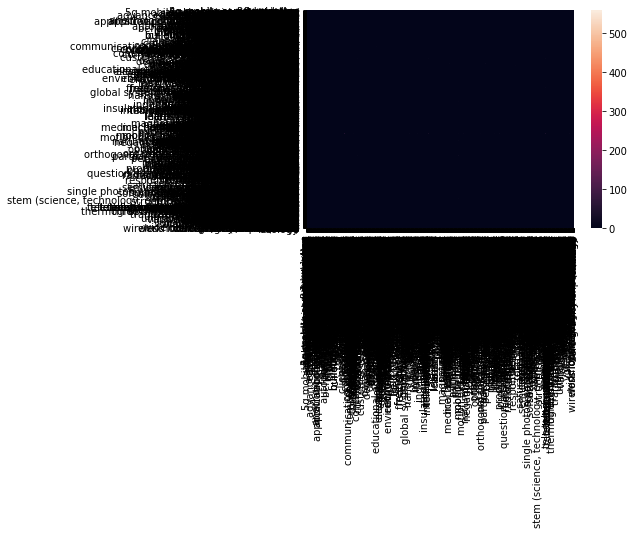

In [141]:
sns.heatmap(df_table,xticklabels=varnames, yticklabels=varnames)

In [8]:
df_table.to_csv('coocurrences-lowlevel-relevant.csv')

In [9]:
for i in range(0, len(varnames)):
    print(varnames[i])

3d modeling
3d printers
5g mobile communication
5g mobile communication systems
ability testing
ablation
abstracting
academic libraries
accelerometers
acoustic field measurement
acoustic fields
acoustic imaging
acoustic intensity
acoustic measurement
acoustic signal processing
acoustic streaming
actuators
adaptive algorithms
adaptive optics
adaptive systems
advanced driver assistance systems
advertising data processing
aerial photography
aerospace computing
aerospace engineering
aerospace industry
aerospace propulsion
age issues
aging of materials
agricultural engineering
agricultural robots
agriculture
air navigation
air traffic control
aircraft
aircraft control
aircraft displays
aircraft maintenance
aircraft manufacture
aircraft navigation
ambient intelligence
ambulances
android (operating system)
animation
antenna arrays
antennas
anthropomorphic robots
application programming interfaces (api)
application programs
application specific integrated circuits
approximation algorithms
appr

In [167]:
len(midlvl_names)

61

In [35]:
two_words = []
three_words = []

In [43]:
import re
code_keywords =[]
for i in range(0,len(dataset)):
    if i in dataset.index:
        code_keys = dataset['Classification code'][i]
        code_keys = re.split(';', code_keys)
        code_keywords.append(code_keys)

In [36]:
for i in range(0,len(rep_w_all_names)):
    for j in range (0, len(rep_w_all_names)):
        word_set = []
        first_word = rep_w_all_names[i]
        second_word = rep_w_all_names[j]
        if first_word != second_word:
            word_set.append(first_word)
            word_set.append(second_word)
            two_words.append(word_set)
            
for i in range(0,len(rep_w_all_names)):
    for j in range (0, len(rep_w_all_names)):
        for k in range(0,len(rep_w_all_names)):
            word_set = []
            first_word = rep_w_all_names[i]
            second_word = rep_w_all_names[j]
            third_word = rep_w_all_names[k]
            if first_word != second_word and first_word != third_word and second_word != third_word:
                word_set.append(first_word)
                word_set.append(second_word)
                word_set.append(third_word)
                three_words.append(word_set)


In [91]:
index = []
for i in range (0, len(cooccur_names)):
    word1 = cooccur_names[i][0]
    word2 = cooccur_names[i][1]
    if word1 == word2:
        index.append(i)
        del cooccur_names[i]

IndexError: list index out of range

In [38]:
two_words_ = two_words     
for i in range(0, len(two_words)):
    for j in range(0, len(two_words)):
        if i != j:
            #print(str(i)+' '+str(j))
            jaccard_words = jaccard_similarity(two_words[i], two_words[j])
            two_words_.remove(two_words[j])

IndexError: list index out of range

In [79]:
cooccur_names = []
for i in range (0,len(rep_w_all_names)):
    for j in range (0,len(rep_w_all_names)):
        word_1 = rep_w_all_names[i]
        word_2 = rep_w_all_names[j]
        words = [word_1, word_2]
        cooccur_names.append(words)

In [18]:
table[0]

array([ 0,  5,  0,  0,  1,  7,  0,  1, 83,  0,  5,  1,  0,  0,  0,  0,  0,
        1,  3,  0,  0,  1,  0, 13,  0,  2,  0,  8,  0,  0,  2,  0,  0,  0,
        0,  1, 10,  0,  0,  0,  1,  0,  0,  0,  0,  3,  2,  0, 38, 29,  0,
        0,  2,  0,  1,  0,  2,  0,  0,  5,  0,  0,  0,  0,  0,  1,  0,  2,
        1,  0, 61,  0,  0,  0,  0, 13,  0,  0,  0,  0,  3,  0,  0,  0,  0,
        0,  0,  3,  0,  0,  1,  1,  1,  0,  1,  1,  0,  6,  6,  1,  4,  1,
        0,  4,  1,  0,  1,  0,  0,  1,  0,  6,  0,  2, 18,  0, 20,  0])

In [45]:
jaccard_entry = np.zeros((len(entry_list),len(entry_list)))
for i in range(0,len(entry_list)):
    for j in range (0,len(entry_list)):
        #print('('+str(i)+', '+str(j)+')')
        score = jaccard_similarity(entry_list[i], entry_list[j]);
        jaccard_entry[i][j] = score;  

In [141]:
midlvl_names = ['accessibility','acoustics','aerospace','artifical intelligence','assembly',
               'augmented reality','automation','automobiles','color','computer vision','computing',
                'construction','control','controllers','data modeling','display technology','education',
                'emergency management','energy management','entertainment','food and agriculture','handheld computing',
                'hardware','holography','human computer interaction','human factors','human resources','image processing',
                'information systems','infrastructure','lighting','location based services','machinery','magnetics',
                'maintenance','manufacturing','marketing','materials','mathematics','medical applications','military',
                'mixed reality','mobile computing','operating system','optics','physics','policy','programming language',
                'quality management','risk','robotics','safety','security','sensors','simulation','sustainability',
                'training','transportation','virtual reality','wearables','web services']

In [50]:
table

array([[ 0,  5,  0, ...,  0, 20,  0],
       [ 5,  0,  2, ...,  0,  6,  0],
       [ 0,  2,  0, ...,  0,  7,  1],
       ...,
       [ 0,  0,  0, ...,  0,  1,  0],
       [20,  6,  7, ...,  1,  0,  7],
       [ 0,  0,  1, ...,  0,  7,  0]])

In [66]:
len(midlvl_names)

59

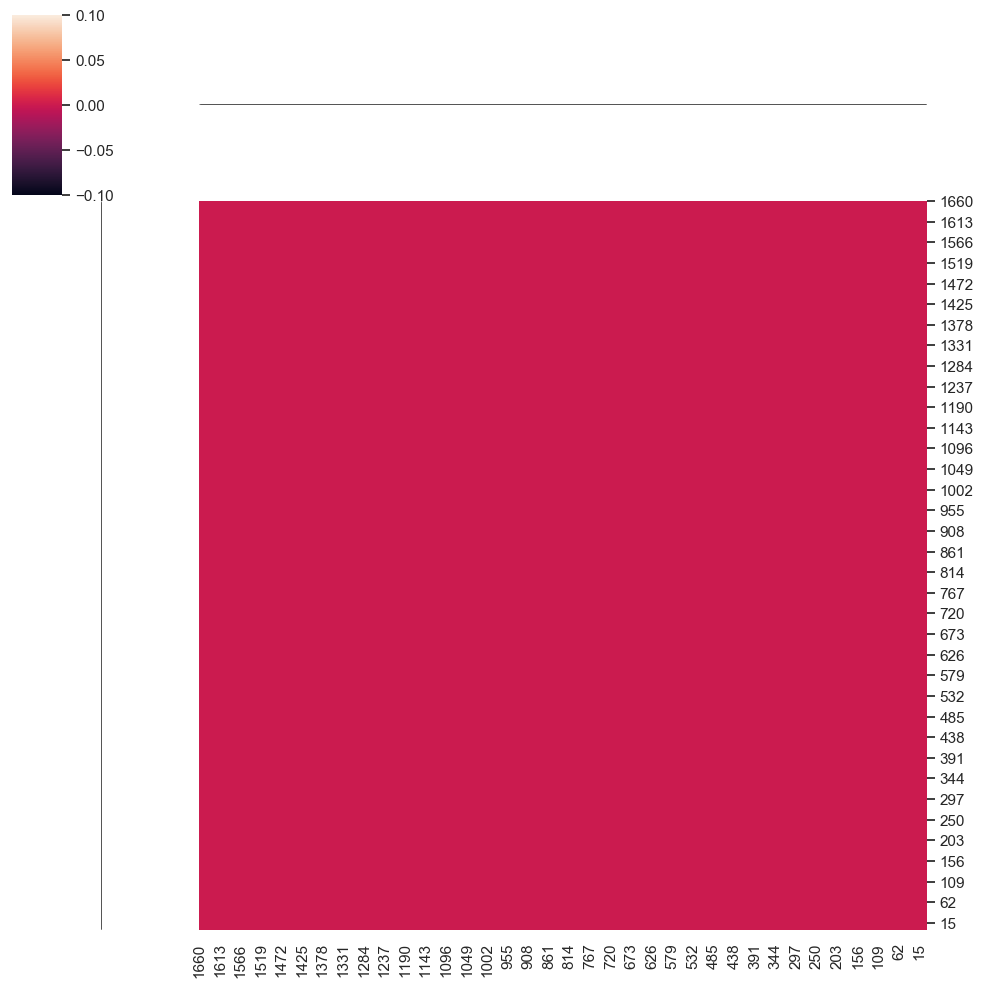

In [47]:
ax = sns.clustermap(jaccard_code, linewidth=0.0)
sns.set(font_scale=0.5)
sns.set(rc={'figure.figsize':(100,100)})
plt.show()

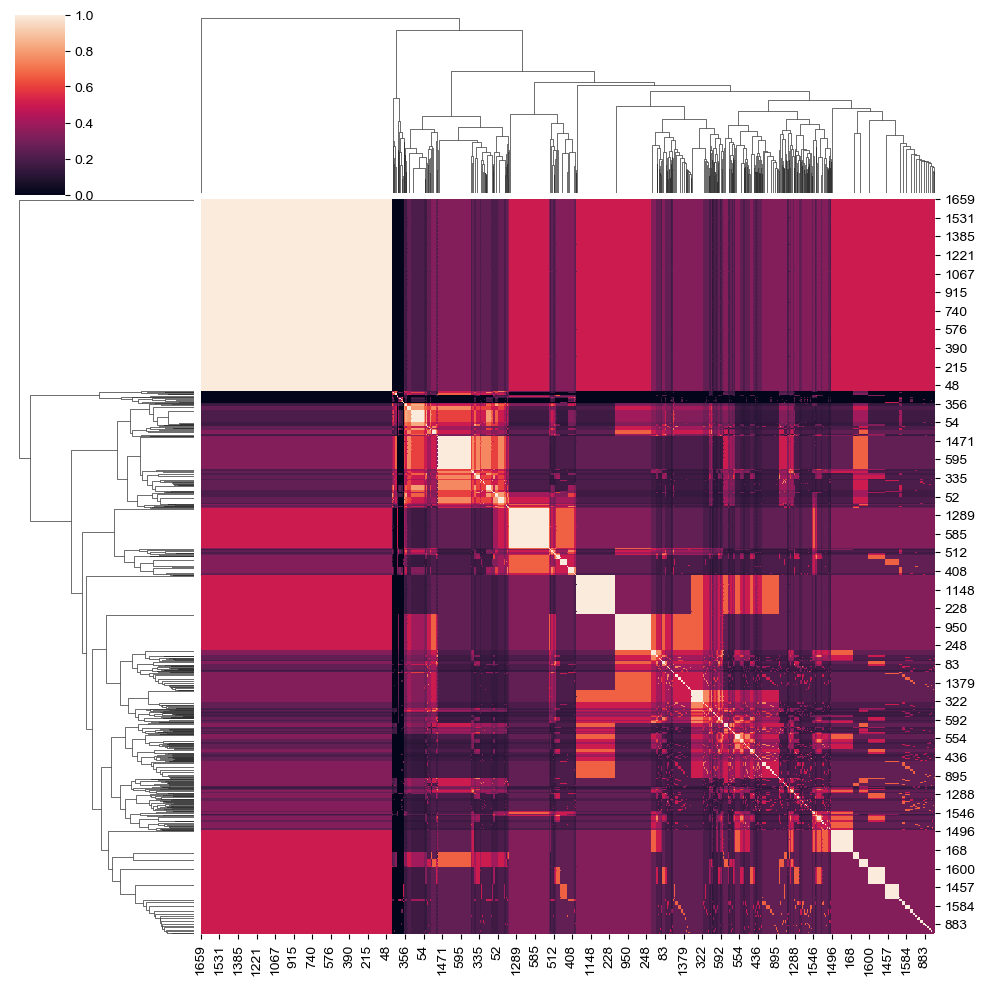

In [46]:
ax = sns.clustermap(jaccard_entry, linewidth=0.0)
sns.set(rc={'figure.figsize':(13,13)})
plt.show()

In [ ]:
entry_list[3687]

In [ ]:
order = ax.dendrogram_row.reordered_ind

In [ ]:
file1 = open("MyFile.txt","w") 
for i in range (0, len(order)):
    file1.write(str(order[i])+','+str(entry_list[order[i]]) +'\n')
file1.close() 


In [ ]:
from IPython.display import Image
Image("labeled-clusters.png")

In [ ]:
print(entry_list[2016])
print(entry_list[3367])
print(entry_list[4259])
print(entry_list[3006])
print(entry_list[3117])
print(entry_list[587])
print(entry_list[3807])
print(entry_list[2100])
print(entry_list[2064])
print(entry_list[2900])
print(entry_list[2084])
print(entry_list[2247])
print(entry_list[2326])
print(entry_list[2473])

In [ ]:
mlb2 = MultiLabelBinarizer()
mlb2.fit_transform(control_keywords)
list(mlb2.classes_)

In [ ]:

control_keywords =[]
for i in range(0,len(dataset)):
    control_keys = dataset['ControlledSubjectTermsOriginal'][i]
    control_keys = re.split('; ', control_keys)
    control_keywords.append(control_keys)


In [ ]:
for i in range(0,len(control_keywords)):
    for j in range (0,len(control_keywords)):
        score = jaccard_similarity(control_keywords[i], control_keywords[j]);
        score2 = jaccard_similarity(uncontrol_keywords[i], uncontrol_keywords[j]);
        score3 = jaccard_similarity(classification_code[i], classification_code[j])
        jaccard_control[i][j] = score;
        jaccard_uncontrol[i][j] = score2;
        jaccard_code[i][j] = score3;

In [ ]:
## Some example of 'clean' controlled keywords
control_keywords[8:15]

In [ ]:
## Some example of 'clean' uncontrolled keywords
uncontrol_keywords[8:15]

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt

In [ ]:
ax = sns.clustermap(jaccard_control, linewidth=0.0)
sns.set(rc={'figure.figsize':(13,13)})
plt.show()

In [ ]:
ax = sns.clustermap(jaccard_entry, linewidth=0.0)
sns.set(rc={'figure.figsize':(13,13)})
plt.show()

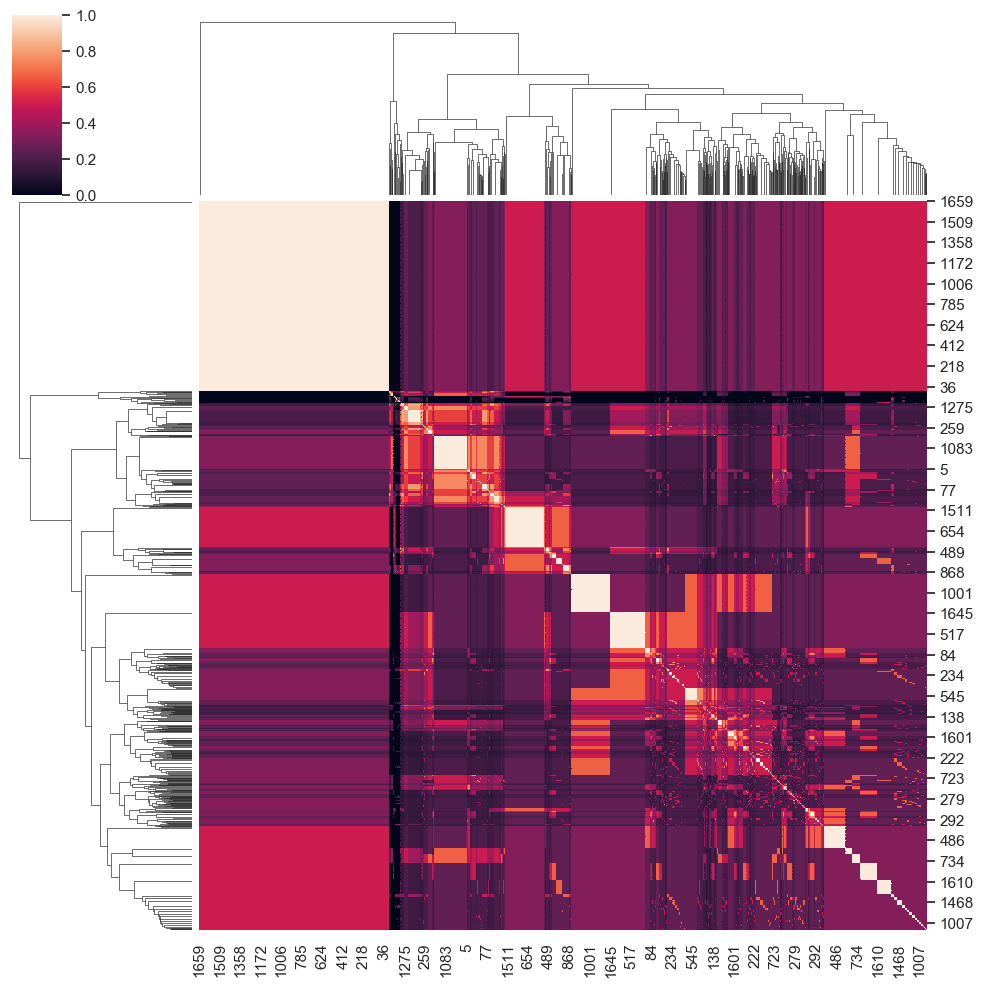

In [48]:
ax = sns.clustermap(jaccard_entry, linewidth=0.0)
sns.set(rc={'figure.figsize':(13,13)})
plt.show()

In [ ]:
ax = sns.clustermap(jaccard_control, linewidth=0.0)
sns.set(rc={'figure.figsize':(13,13)})
plt.show()

In [ ]:
ax = sns.clustermap(jaccard_uncontrol, linewidth=0.0)
sns.set(rc={'figure.figsize':(13,13)})
plt.show()

In [ ]:
classification_code[1338]

In [ ]:
classification_code[1065]

In [ ]:
classification_code[4161]

In [ ]:
# Libraries for text preprocessing
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer

In [ ]:
##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords
#new_words = ["br", "use", "award","project","research","using","new","based","nsf","develop","application"] 
#stop_words = stop_words.union(new_words)

In [ ]:
corpus = []
for i in range(0, 263):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', dataset['Abstract'][i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

## View corpus item
corpus[5]

In [ ]:
#Word cloud
#import wordcloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import re
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [ ]:
list(cv.vocabulary_.keys())[:10]

In [ ]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pandas.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30);

In [ ]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(corpus, n=20)
top3_df = pandas.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
#print(top3_df);
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45);

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()
 
# fetch document for which keywords needs to be extracted
doc=corpus[15]
 
#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

In [ ]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,5)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])

In [ ]:
dataset.ControlledSubjectTerms.str.split(";").values
#can be dumped directly into multi-label binarizer (sklearn)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html
# sexton github: https://github.com/tbsexton/organizing-tags/blob/54485a338fc5ce515f004541f7a1f2b7bd5ed182/src/tools.py#L37

In [ ]:
from sklearn import preprocessing as pre
from sklearn.metrics.pairwise import cosine_similarity

def cosine_model(m, classes=None, **cos_kws):

    encode = pre.MultiLabelBinarizer(classes=classes)
    tags = encode.fit_transform(m)

    cos = cosine_similarity(tags.T.dot(tags))
    cos -= np.diag(cos.diagonal())
    return cos

In [ ]:
cosine_model(dataset.ControlledSubjectTerms.str.split(";"))
m=dataset.ControlledSubjectTerms.str.split(";")
encode = pre.MultiLabelBinarizer()
tags = encode.fit_transform(m)

cos = cosine_similarity(tags.T.dot(tags))
cos -= np.diag(cos.diagonal())



In [ ]:
#dataset = paper_dataset
#Fetch wordcount for each abstract
dataset['word_count'] = dataset['Abstract'].apply(lambda x: len(str(x).split(" ")))
dataset[['Abstract','word_count']].head()